## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import celltypist
import logging
from matplotlib.colors import Normalize, LinearSegmentedColormap
import math
import pickle

In [3]:
# Set seeds
scvi.settings.seed = 0
scvi.settings.verbosity = logging.WARNING

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False

cmap = sns.color_palette("colorblind")
tab20_cmap = plt.get_cmap('tab20')
colors_to_exclude = [6, 7]  # 0-based index, so 6 and 7 represent the 7th and 8th colors
new_tab20 = [tab20_cmap(i) for i in range(tab20_cmap.N) if i not in colors_to_exclude]

In [5]:
warnings.resetwarnings()

# Import data

Data paths

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs_final.h5ad")
model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes",
    adata=adata,
)

Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


# Subclustering Immature MECs

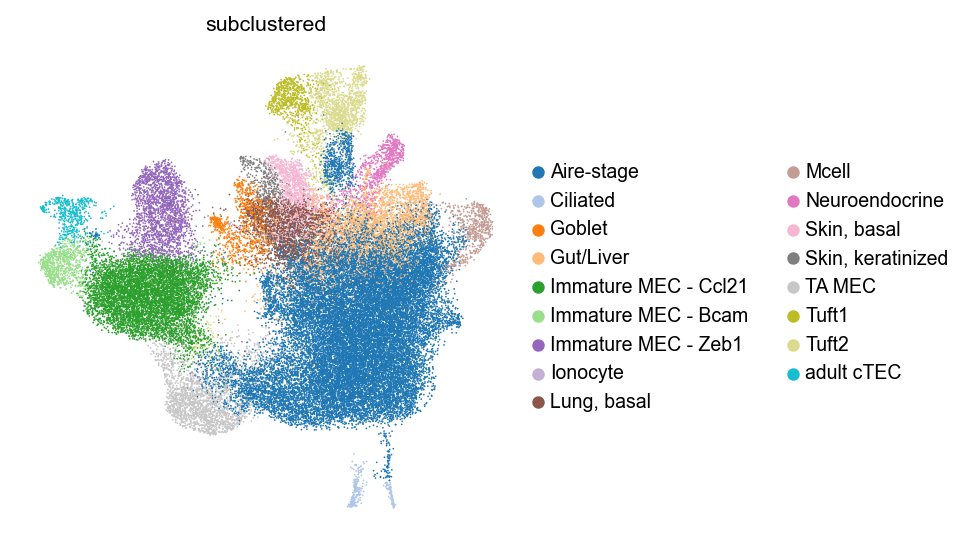

In [9]:
adata.obs.subclustered = adata.obs.subclustered.astype(str).astype("category")
cats = adata.obs.subclustered.cat.categories.tolist()
cats[4], cats[5] = cats[5], cats[4]
adata.obs.subclustered = adata.obs.subclustered.cat.reorder_categories(new_categories=cats)

sc.pl.umap(
    adata,
    color="subclustered",
    palette=new_tab20
)

In [10]:
subset_data = adata[adata.obs.subclustered == "Aire-stage"].copy()

In [11]:
sc.tl.leiden(
    subset_data,
    resolution=0.16,
    key_added="subclustering_leiden"
)

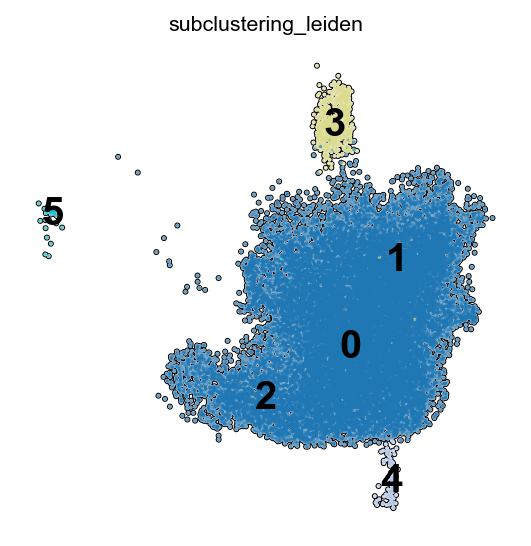

In [12]:
sc.settings.figdir = "../../analysis/subclustering/"
sc.pl.umap(
    subset_data,
    color="subclustering_leiden",
    legend_loc="on data",
    palette=[new_tab20[0], new_tab20[0], new_tab20[0], new_tab20[15], new_tab20[1], new_tab20[16]],
    legend_fontsize=18,
    add_outline=True,
    s=10,
    save="_aire_stage_subclustered.pdf"
)

## Add subcluster labels to full dataset

In [13]:
adata.obs["subclustered"] = adata.obs.subclustered.astype("str")
adata.obs.loc[adata.obs.subclustered == "Aire-stage", "subclustered"] = subset_data.obs.subclustering_leiden

# Subcluster DE

In [14]:
de_dfs = {}
de_dfs_unfiltered = {}
for subcluster in ["0", "1", "2", "3", "4", "5"]:
    de = model.differential_expression(
        adata[adata.obs.genotype == "WT"],
        groupby="subclustered",
        group1=subcluster,
    )
    de_df_filtered = de[de.lfc_mean > 0].copy()
    de_df_filtered = de_df_filtered[de_df_filtered.bayes_factor > 3]
    de_df_filtered = de_df_filtered[de_df_filtered.non_zeros_proportion1 > 0.1]
    de_dfs[subcluster] = de_df_filtered.sort_values(by="bayes_factor", ascending=False)
    de_dfs_unfiltered[subcluster] = de.sort_values(by="bayes_factor", ascending=False)

DE...: 100%|██████████| 1/1 [00:40<00:00, 40.16s/it]


## subcluster 0/1/2 - Aire 

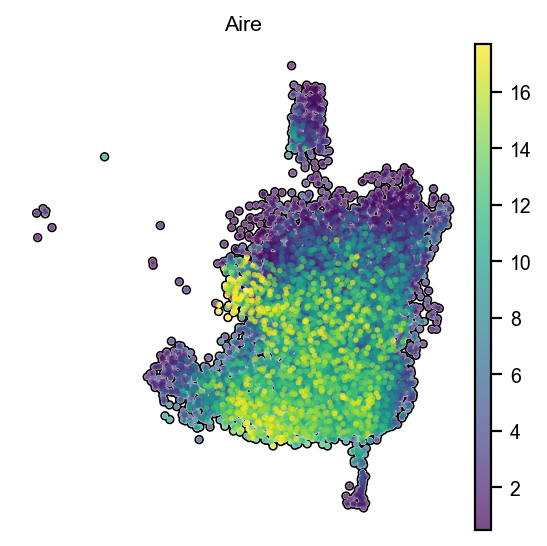

In [15]:
gene_list = ["Aire"]
vmin = []
vmax = []
for gene in gene_list:
    expr = subset_data[subset_data.obs.genotype=="WT", gene].layers["scVI_normalized"]
    vmin.append(np.quantile(expr, 0.01))
    vmax.append(np.quantile(expr, 0.99))

sc.settings.figdir = "../../analysis/subclustering/"
sc.pl.umap(
    subset_data[subset_data.obs.genotype=="WT"],
    layer="scVI_normalized",
    color=gene_list,
    s=25,
    vmin=vmin,
    vmax=vmax,
    add_outline=True,
    save="_aire_stage_subcluster_DE_features.pdf"
)

## subcluster 3 - Tuft2

In [16]:
de_dfs["3"].head(15).index.tolist()

['Rgs13',
 'Irag2',
 'A630073D07Rik',
 'Mctp1',
 'Pou2af2',
 'Ly6g6f',
 'Gng13',
 'Plcb2',
 'Bmx',
 'Sh2d7',
 'Alox5',
 'Gnb3',
 'Vav1',
 'Pik3r5',
 'Gm4952']

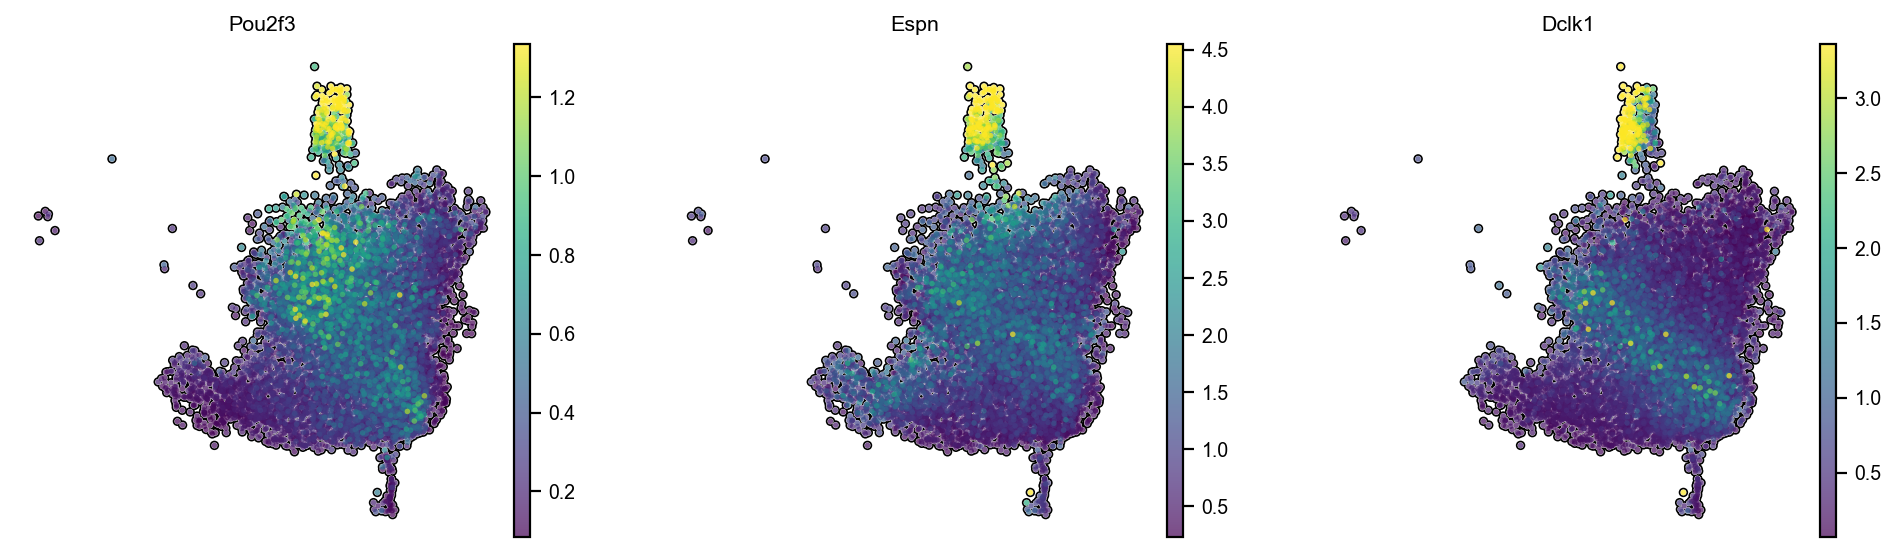

In [17]:
gene_list = ["Pou2f3", "Espn", "Dclk1"]
vmin = []
vmax = []
for gene in gene_list:
    expr = subset_data[subset_data.obs.genotype=="WT", gene].layers["scVI_normalized"]
    vmin.append(np.quantile(expr, 0.01))
    vmax.append(np.quantile(expr, 0.99))

sc.settings.figdir = "../../analysis/subclustering/"
sc.pl.umap(
    subset_data[subset_data.obs.genotype == "WT"],
    layer="scVI_normalized",
    color=gene_list,
    s=25,
    vmin=vmin,
    vmax=vmax,
    add_outline=True,
    save="_Aire_stage_reannoated_tuft_subcluster_DE_features.pdf"
)

## subcluster 4 - ciliated

In [18]:
de_dfs["4"].head(15).index.tolist()

['Mcidas',
 'Ccno',
 'Deup1',
 'Shisa8',
 'Hyls1',
 'Fam216a',
 'Cdc20b',
 'Pidd1',
 'Trp73',
 'Foxn4',
 'Zmynd10',
 'Ccdc61',
 'Slc17a8',
 'Rnf32',
 'Cfap161']

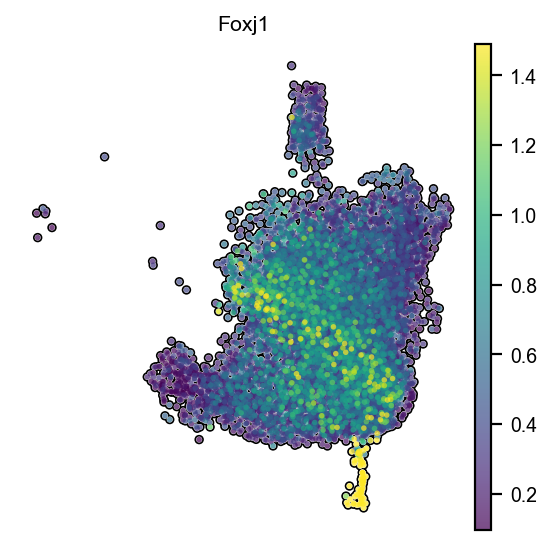

In [19]:
gene_list = ["Foxj1"]
vmin = []
vmax = []
for gene in gene_list:
    expr = subset_data[subset_data.obs.genotype=="WT", gene].layers["scVI_normalized"]
    vmin.append(np.quantile(expr, 0.01))
    vmax.append(np.quantile(expr, 0.99))

sc.settings.figdir = "../../analysis/subclustering/"
sc.pl.umap(
    subset_data[subset_data.obs.genotype=="WT"],
    layer="scVI_normalized",
    color=gene_list,
    s=25,
    vmin=vmin,
    vmax=vmax,
    add_outline=True,
    save="_ciliated_subcluster_DE_features.pdf"
)

## subcluster 5 - adult cTEC

In [20]:
de_dfs["5"].head(15).index.tolist()

['Prss16',
 'Plekhb1',
 'Kcnk2',
 'Psmb11',
 'Ndrg3',
 'Cxcl12',
 'Dusp28',
 'Synm',
 'Syngr1',
 'Klf15',
 'Diras2',
 'Mrpl3',
 'Castor1',
 'Pltp',
 'Ctsl']

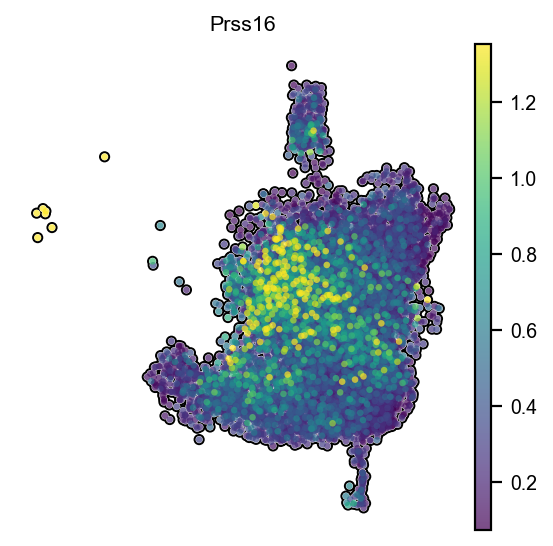

In [21]:
gene_list = ["Prss16"]
vmin = []
vmax = []
for gene in gene_list:
    expr = subset_data[subset_data.obs.genotype=="WT", gene].layers["scVI_normalized"]
    vmin.append(np.quantile(expr, 0.01))
    vmax.append(np.quantile(expr, 0.99))

sc.settings.figdir = "../../analysis/subclustering/"
sc.pl.umap(
    subset_data[subset_data.obs.genotype=="WT"],
    layer="scVI_normalized",
    color=gene_list,
    s=35,
    vmin=vmin,
    vmax=vmax,
    add_outline=True,
    save="_doublets_subcluster_DE_features.pdf"
)

## Rename subsets

In [22]:
rename_dict = {
    "0": "Aire-stage",
    "1": "Aire-stage",
    "2": "Aire-stage",
    "3": "Tuft2",
    "5": "adult cTEC",
    "4": "Ciliated"
}
adata.obs.subclustered = adata.obs.subclustered.replace(rename_dict)
adata.obs.subclustered = adata.obs.subclustered.astype("category")
cats = adata.obs.subclustered.cat.categories.tolist()
cats[4], cats[5] = cats[5], cats[4]
adata.obs.subclustered = adata.obs.subclustered.cat.reorder_categories(new_categories=cats)

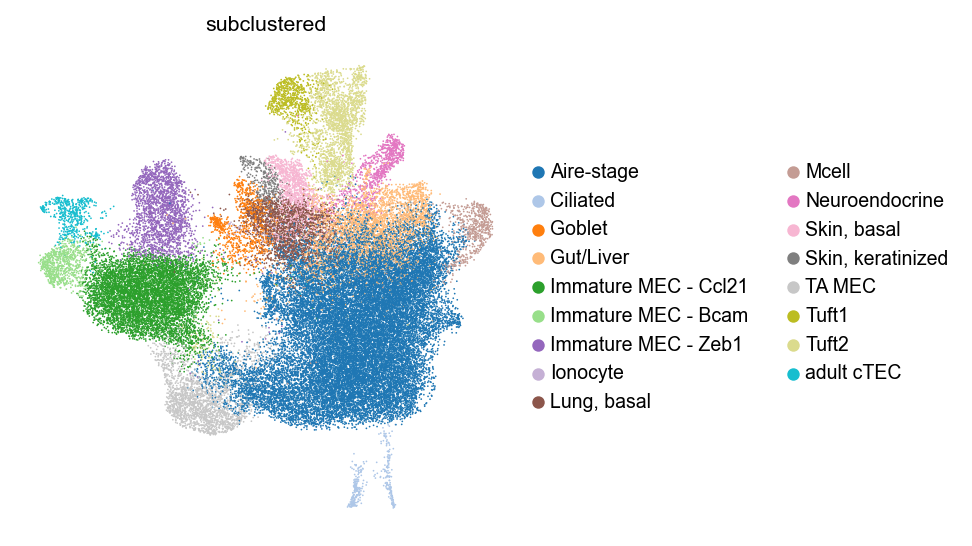

In [23]:
sc.pl.umap(
    adata,
    color="subclustered",
    palette=new_tab20,
    # add_outline=True,
)

In [24]:
adata.write(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs_final.h5ad")